<a href="https://colab.research.google.com/github/thewildox/Black-Scholes-Option-Pricing-And-Greeks-Analysis-for-AAPL-Options/blob/main/Black_Scholes_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black-Scholes Option Pricing & Greeks Analysis for AAPL Options
This notebook pulls real AAPL stock and option chain data from Yahoo Finance,
prices European call and put options using the Black-Scholes formula,
computes all main Greeks (Delta, Gamma, Vega, Theta, Rho),
visualizes market vs model prices, plots Greeks vs strike price,
and allows interactive exploration of volatility and time to maturity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
from ipywidgets import interact, FloatSlider
from datetime import datetime

In [ ]:
#Black-Scholes Model
def d1_d2(S, K, T, r, sigma):
  """
  Calculate d1 and d2 for the Black-Scholes model.
  """
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  return d1, d2

def call_price(S, K, T, r, sigma):
  """
  Calculate the call option price using the Black-Scholes model.
  """
  d1, d2 = d1_d2(S, K, T, r, sigma)
  price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return price

def put_price(S, K, T, r, sigma):
  """
  Calculate the call option price using the Black-Scholes model.
  """
  d1, d2 = d1_d2(S, K, T, r, sigma)
  price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
  return price

In [ ]:
#Compute Greeks
def delta_call(S, K, T, r, sigma):
    """
    Calculate the Delta of a European Call option.
    Delta measures the sensitivity of the option price to a $1 change in the underlying stock price.
    """
    d1, _ = d1_d2(S, K, T, r, sigma)
    return norm.cdf(d1)


def delta_put(S, K, T, r, sigma):
    """
    Calculate the Delta of a European Put option.
    Delta measures the sensitivity of the option price to a $1 change in the underlying stock price.
    """
    d1, _ = d1_d2(S, K, T, r, sigma)
    return norm.cdf(d1) - 1


def gamma(S, K, T, r, sigma):
    """
    Calculate the Gamma of a European option (same for Call and Put).
    Gamma measures the rate of change of Delta with respect to changes in the underlying stock price.
    """
    d1, _ = d1_d2(S, K, T, r, sigma)
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))


def vega(S, K, T, r, sigma):
    """
    Calculate the Vega of a European option (same for Call and Put).
    Vega measures the sensitivity of the option price to a 1% change in volatility.
    """
    d1, _ = d1_d2(S, K, T, r, sigma)
    return S * norm.pdf(d1) * np.sqrt(T) / 100


def theta_call(S, K, T, r, sigma):
    """
    Calculate the Theta (time decay) of a European Call option.
    Theta measures the rate at which the option loses value as time passes, holding other factors constant.
    """
    d1, d2 = d1_d2(S, K, T, r, sigma)
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             - r * K * np.exp(-r * T) * norm.cdf(d2))
    return theta / 365


def theta_put(S, K, T, r, sigma):
    """
    Calculate the Theta (time decay) of a European Put option.
    Theta measures the rate at which the option loses value as time passes, holding other factors constant.
    """
    d1, d2 = d1_d2(S, K, T, r, sigma)
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             + r * K * np.exp(-r * T) * norm.cdf(-d2))
    return theta / 365


def rho_call(S, K, T, r, sigma):
    """
    Calculate the Rho of a European Call option.
    Rho measures the sensitivity of the option price to a 1% change in the risk-free interest rate.
    """
    _, d2 = d1_d2(S, K, T, r, sigma)
    return K * T * np.exp(-r * T) * norm.cdf(d2) / 100


def rho_put(S, K, T, r, sigma):
    """
    Calculate the Rho of a European Put option.
    Rho measures the sensitivity of the option price to a 1% change in the risk-free interest rate.
    """
    _, d2 = d1_d2(S, K, T, r, sigma)
    return -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100


In [ ]:
# Pull current stock price
ticker = "AAPL"
stock = yf.Ticker(ticker)

#Get the last closing price
S = stock.history(period="1d")["Close"].iloc[-1]
print(f"Current {ticker} stock price: ${S:.2f}")

Current AAPL stock price: $267.26


In [ ]:
K = round(S)
R = 0.05

expirations = stock.options
expiration = expirations[0]
expiry_date = datetime.strptime(expiration, "%Y-%m-%d")
T_days = (expiry_date - datetime.today()).days
T = T_days / 365

In [ ]:
#Load Option Chain
option_chain = stock.option_chain(expiration)
calls = option_chain.calls.copy()
puts = option_chain.puts.copy()

In [ ]:
def compute_metrics(df, option_type="call", S=S, T=T, r=r):
    """
    Compute Black-Scholes prices and all Greeks for a given option chain DataFrame.
    Adds columns: BS_Price, Delta, Gamma, Vega, Theta, Rho
    """
    prices, deltas, gammas, vegas, thetas, rhos = [], [], [], [], [], []
    for idx,row in df.iterrows():
        K = row['strike']
        sigma = row['impliedVolatility'] if row['impliedVolatility']>0 else 0.25
        if option_type=="call":
            prices.append(call_price(S,K,T,r,sigma))
            deltas.append(delta_call(S,K,T,r,sigma))
            thetas.append(theta_call(S,K,T,r,sigma))
            rhos.append(rho_call(S,K,T,r,sigma))
        else:
            prices.append(put_price(S,K,T,r,sigma))
            deltas.append(delta_put(S,K,T,r,sigma))
            thetas.append(theta_put(S,K,T,r,sigma))
            rhos.append(rho_put(S,K,T,r,sigma))
        gammas.append(gamma(S,K,T,r,sigma))
        vegas.append(vega(S,K,T,r,sigma))
    df['BS_Price']=prices
    df['Delta']=deltas
    df['Gamma']=gammas
    df['Vega']=vegas
    df['Theta']=thetas
    df['Rho']=rhos
    return df

calls = compute_metrics(calls, "call")
puts = compute_metrics(puts, "put")

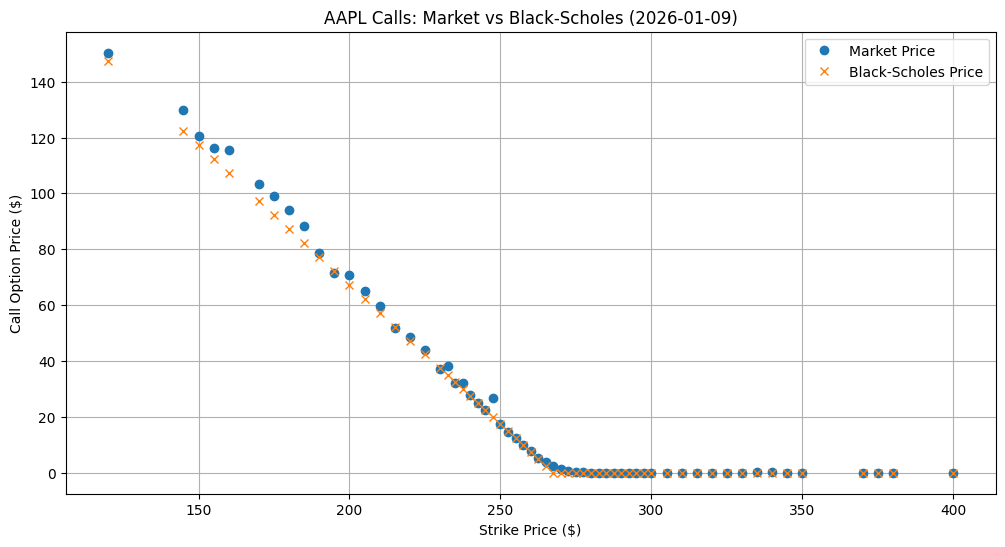

In [ ]:
#Visualizations Market vs Black-Scholes
plt.figure(figsize=(12,6))
plt.plot(calls['strike'], calls['lastPrice'], 'o', label='Market Price')
plt.plot(calls['strike'], calls['BS_Price'], 'x', label='Black-Scholes Price')
plt.xlabel("Strike Price ($)")
plt.ylabel("Call Option Price ($)")
plt.title(f"AAPL Calls: Market vs Black-Scholes ({expiration})")
plt.legend()
plt.grid(True)
plt.show()

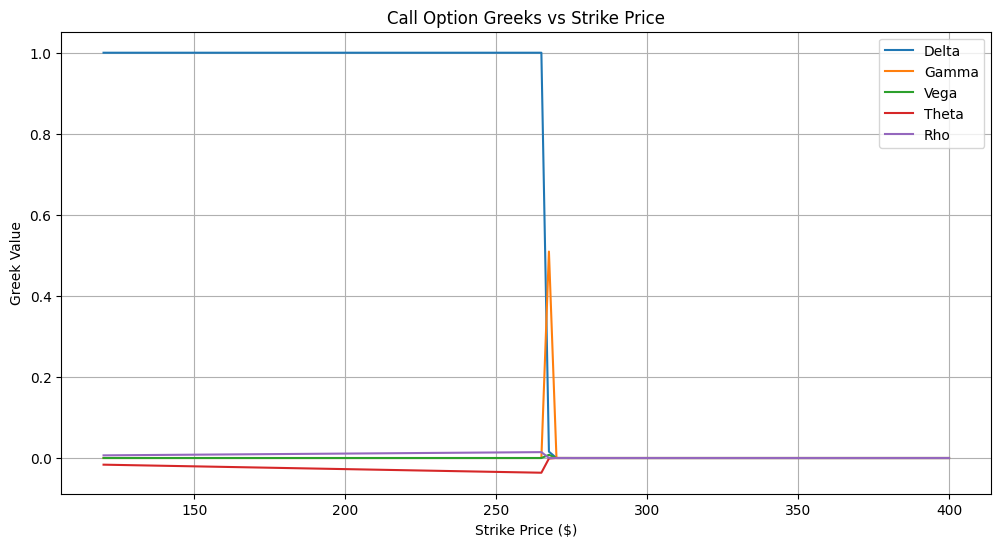

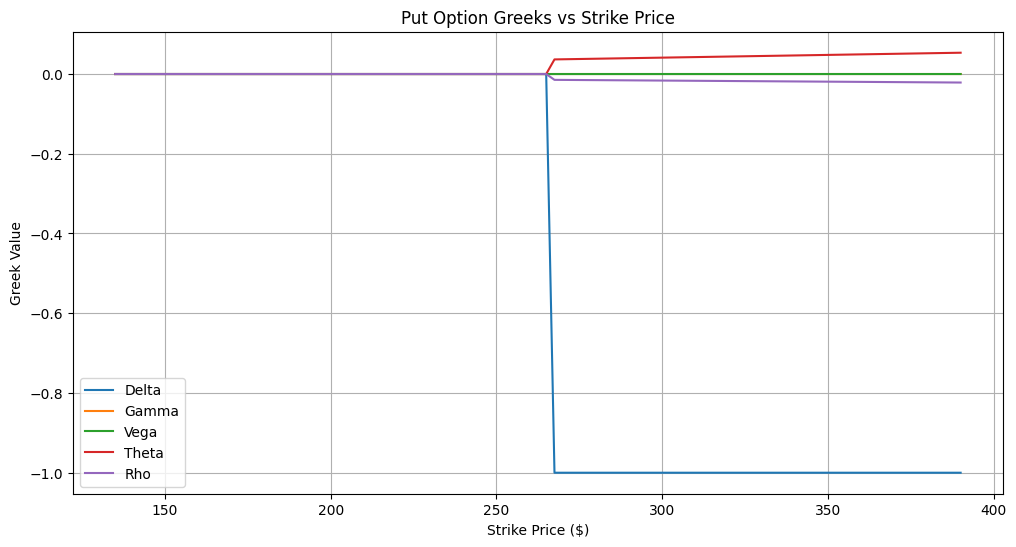

In [ ]:
def plot_greeks(df, option_type="call"):
    plt.figure(figsize=(12,6))
    plt.plot(df['strike'], df['Delta'], label='Delta')
    plt.plot(df['strike'], df['Gamma'], label='Gamma')
    plt.plot(df['strike'], df['Vega'], label='Vega')
    plt.plot(df['strike'], df['Theta'], label='Theta')
    plt.plot(df['strike'], df['Rho'], label='Rho')
    plt.xlabel("Strike Price ($)")
    plt.ylabel("Greek Value")
    plt.title(f"{option_type.capitalize()} Option Greeks vs Strike Price")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_greeks(calls, "call")
plot_greeks(puts, "put")


In [ ]:
def interactive_call_price(volatility=0.25, days_to_expiry=T_days):
    T_adj = days_to_expiry/365
    call_prices = [call_price(S,row['strike'],T_adj,r,volatility) for idx,row in calls.iterrows()]
    plt.figure(figsize=(12,6))
    plt.plot(calls['strike'], calls['lastPrice'], 'o', label='Market Price')
    plt.plot(calls['strike'], call_prices, 'x', label='Black-Scholes Price')
    plt.xlabel("Strike Price ($)")
    plt.ylabel("Call Option Price ($)")
    plt.title(f"AAPL Calls: Market vs Black-Scholes (Vol={volatility*100:.1f}%, Days={days_to_expiry})")
    plt.legend()
    plt.grid(True)
    plt.show()

interact(interactive_call_price,
         volatility=FloatSlider(min=0.05,max=0.6,step=0.01,value=0.25),
         days_to_expiry=FloatSlider(min=1,max=90,step=1,value=T_days));


interactive(children=(FloatSlider(value=0.25, description='volatility', max=0.6, min=0.05, step=0.01), FloatSl…